In [1]:
pip install protobuf==3.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-me

In [2]:
import keras
from keras import ops
from keras import layers

2025-11-29 16:55:10.799023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764435311.055237      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764435311.130252      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [4]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# -------------------------
# Parameters
# -------------------------
vocab_size = 20000
maxlen = 200
oov_token = "<OOV>"

# -------------------------
# Load CSV
# -------------------------
df = pd.read_csv("/kaggle/input/kazakh-reviews/kazakh_reviews.csv")

print("Dataset shape:", df.shape)
print(df.head())

# -------------------------
# Extract columns
# -------------------------
# Change these if your CSV uses other names
text_col = "combined_text"
label_col = "label"

sentiment_to_label = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}

# Create new numeric column
df["label"] = df["sentiment"].map(sentiment_to_label)

texts = df[text_col].astype(str).tolist()
labels = df[label_col].astype(int).values

# -------------------------
# Train/Validation Split
# -------------------------
x_train_texts, x_val_texts, y_train, y_val = train_test_split(
    texts,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

print("Training samples:", len(x_train_texts))
print("Validation samples:", len(x_val_texts))

# -------------------------
# Tokenizer
# -------------------------
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token, filters='')
tokenizer.fit_on_texts(x_train_texts)

# Convert text → sequences
x_train_seq = tokenizer.texts_to_sequences(x_train_texts)
x_val_seq   = tokenizer.texts_to_sequences(x_val_texts)

# Pad sequences
x_train = pad_sequences(x_train_seq, maxlen=maxlen, padding="post", truncating="post")
x_val   = pad_sequences(x_val_seq,   maxlen=maxlen, padding="post", truncating="post")

print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)


Dataset shape: (6756, 7)
   Unnamed: 0.1  Unnamed: 0 language  rating  category  \
0             3           3   kazakh     5.0  perfumes   
1            24          24   kazakh     5.0  perfumes   
2            43          43   kazakh     5.0  perfumes   
3            56          56   kazakh     5.0  perfumes   
4            92          92   kazakh     5.0  perfumes   

                                       combined_text sentiment  
0                              иісі қатты ұнады . \n  positive  
1              keremet !  48 sagatka dein ustaidy \n  positive  
2                 иісі өте керемет ,  маған унада \n  positive  
3  салқын ,  әдемі ,  жағымды жұпар . бірақ иісі ...  positive  
4                                   маған ұнады ! \n  positive  
Training samples: 5404
Validation samples: 1352
x_train shape: (5404, 200)
x_val shape: (1352, 200)


In [6]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

2025-11-29 16:55:32.094811: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [7]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = model.fit(
    x_train, y_train, batch_size=32, epochs=2, validation_data=(x_val, y_val)
)

Epoch 1/2
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.9044 - loss: 0.3648 - val_accuracy: 0.9379 - val_loss: 0.2752
Epoch 2/2
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.9436 - loss: 0.2686 - val_accuracy: 0.9379 - val_loss: 0.2713


43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step

--- Validation Classification Report ---
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        49
           1     0.0000    0.0000    0.0000        35
           2     0.9379    1.0000    0.9679      1268

    accuracy                         0.9379      1352
   macro avg     0.3126    0.3333    0.3226      1352
weighted avg     0.8796    0.9379    0.9078      1352

Saved confusion matrix CSV to: eval_reports/confusion_matrix_Validation.csv


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


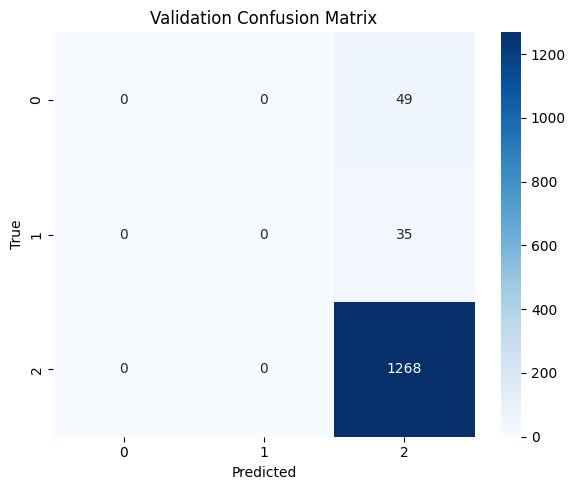

Saved confusion matrix plot to: eval_reports/confusion_matrix_Validation.png

--- Extra Metrics ---
Overall accuracy: 0.9378698224852071
Macro F1: 0.32264631043256997
Weighted F1: 0.9078007136727043
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

--- Test Classification Report ---
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        49
           1     0.0000    0.0000    0.0000        35
           2     0.9379    1.0000    0.9679      1268

    accuracy                         0.9379      1352
   macro avg     0.3126    0.3333    0.3226      1352
weighted avg     0.8796    0.9379    0.9078      1352

Saved confusion matrix CSV to: eval_reports/confusion_matrix_Test.csv


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


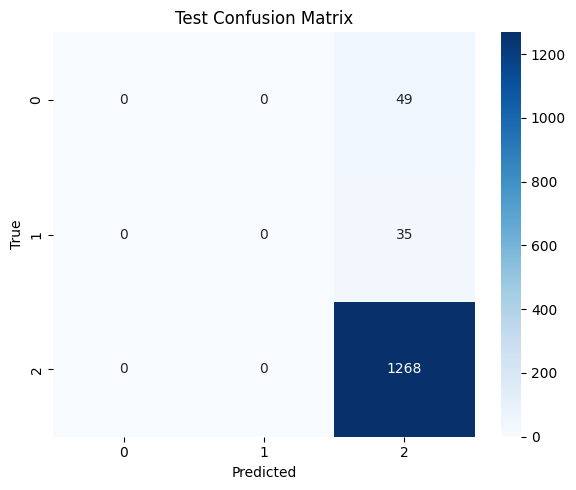

Saved confusion matrix plot to: eval_reports/confusion_matrix_Test.png

--- Extra Metrics ---
Overall accuracy: 0.9378698224852071
Macro F1: 0.32264631043256997
Weighted F1: 0.9078007136727043


In [8]:
# Robust predict-and-report (replacement for the previous function)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import os
import csv

# Try import seaborn; if unavailable, we'll use matplotlib to draw the matrix
try:
    import seaborn as sns
    _has_sns = True
except Exception:
    _has_sns = False

def predict_and_report(model, x, y_true, class_names=None, dataset_name="Validation", save_dir="eval_reports"):
    os.makedirs(save_dir, exist_ok=True)

    # 1) Get predictions (probabilities or logits)
    preds = model.predict(x, verbose=1)

    # Normalize prediction output shapes to decide predicted class:
    # Cases:
    # - preds shape (N, num_classes) -> multiclass; argmax
    # - preds shape (N,) or (N,1) -> binary (probabilities)
    if isinstance(preds, list):  # in case model returns multiple outputs
        preds = np.asarray(preds[0])

    preds = np.asarray(preds)

    if preds.ndim == 1:
        # shape (N,) -> treat as binary prob
        y_pred = (preds > 0.5).astype(int)
        n_classes = 2
    elif preds.ndim == 2 and preds.shape[1] == 1:
        # shape (N,1) -> binary prob
        y_pred = (preds.ravel() > 0.5).astype(int)
        n_classes = 2
    else:
        # multiclass probabilities or logits
        y_pred = np.argmax(preds, axis=1)
        n_classes = preds.shape[1]

    # 2) Decide class names if none provided
    if class_names is None:
        class_names = [str(i) for i in range(n_classes)]

    # 3) Print classification report
    print(f"\n--- {dataset_name} Classification Report ---")
    print(classification_report(y_true, y_pred, digits=4, target_names=class_names))

    # 4) Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_path = os.path.join(save_dir, f"confusion_matrix_{dataset_name.replace(' ', '_')}.csv")
    # Save cm to csv
    with open(cm_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([""] + class_names)
        for i, row in enumerate(cm):
            writer.writerow([class_names[i]] + list(row))
    print(f"Saved confusion matrix CSV to: {cm_path}")

    # 5) Plot confusion matrix (seaborn if available, else matplotlib)
    plt.figure(figsize=(6,5))
    if _has_sns:
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
    else:
        # Matplotlib fallback
        im = plt.imshow(cm, interpolation='nearest', aspect='auto')
        plt.colorbar(im)
        plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
        plt.yticks(np.arange(len(class_names)), class_names)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, str(cm[i, j]),
                         ha="center", va="center", color="white" if cm[i, j] > cm.max()/2 else "black")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.tight_layout()
    plot_path = os.path.join(save_dir, f"confusion_matrix_{dataset_name.replace(' ', '_')}.png")
    plt.savefig(plot_path)
    plt.show()
    print(f"Saved confusion matrix plot to: {plot_path}")

    # 6) Extra metrics
    print("\n--- Extra Metrics ---")
    print("Overall accuracy:", accuracy_score(y_true, y_pred))
    try:
        print("Macro F1:", f1_score(y_true, y_pred, average='macro'))
        print("Weighted F1:", f1_score(y_true, y_pred, average='weighted'))
    except Exception as e:
        print("Could not compute F1:", e)

    return {"y_true": y_true, "y_pred": y_pred, "confusion_matrix": cm}

# Example usage:
# If polarity task (binary), you can give friendly names:
# class_names = ["negative", "positive"]
# For score (5-class): class_names = ["0","1","2","3","4"]
# If you don't know the number of classes, pass None and the function will infer.

# Call for validation set
report_val = predict_and_report(model, x_val, y_val, class_names=None, dataset_name="Validation")

# If you have x_test/y_test defined, evaluate on test as well:
try:
    if 'x_val' in globals() and x_val is not None and 'y_val' in globals() and y_val is not None:
        report_test = predict_and_report(model, x_val, y_val, class_names=None, dataset_name="Test")
    else:
        print("\nNo test set found (x_test/y_test) — skipped test evaluation.")
except Exception as e:
    print("Error while evaluating test set:", e)
